In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.concat((
    pd.read_csv('./data/October_missions_full.csv'),
    pd.read_csv('./data/November_1stW_missions_full.csv'),
), ignore_index=True)

df['mission'] = df['type'] + '_' + df['target'].astype(str)

df = df[['user', 'mission', 'createdAtT', 'type', 'target', 'completed', 'performance']]
df['createdAtT'] = pd.to_datetime(df['createdAtT'], unit='ms').dt.date
df['user'] = df['user'].astype('category').cat.codes
df['mission'] = df['mission'].astype('category')
df['type'] = df['type'].astype('category')

df.sort_values(by=['createdAtT', 'user'], inplace=True, ignore_index=True)
df

,user,mission,createdAtT,type,target,completed,performance
0,0,episode_2,2024-10-01,episode,2,False,0.000000
1,0,action_2,2024-10-01,action,2,False,0.000000
2,0,episode_1,2024-10-01,episode,1,True,1.000000
3,0,quiz_1,2024-10-01,quiz,1,True,1.000000
4,0,quiz_4,2024-10-01,quiz,4,True,1.000000
...,...,...,...,...,...,...,...
110964,8174,activity_7,2024-11-07,activity,7,False,0.000000
110965,8174,quiz_1,2024-11-07,quiz,1,False,0.000000
110966,8195,mobility_3,2024-11-07,mobility,3,False,0.000000
110967,8195,quiz_3,2024-11-07,quiz,3,False,0.333333


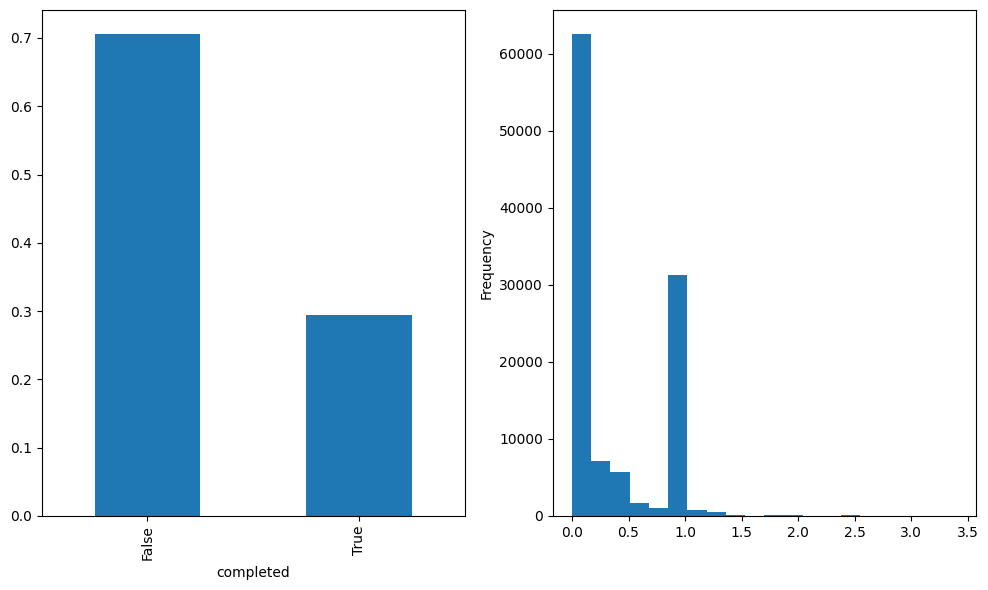

In [2]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['completed'].value_counts(normalize=True).plot(kind='bar')

plt.subplot(1, 2, 2)
df['performance'].plot.hist(bins=20)

plt.tight_layout()
plt.show()

<Axes: xlabel='mission'>

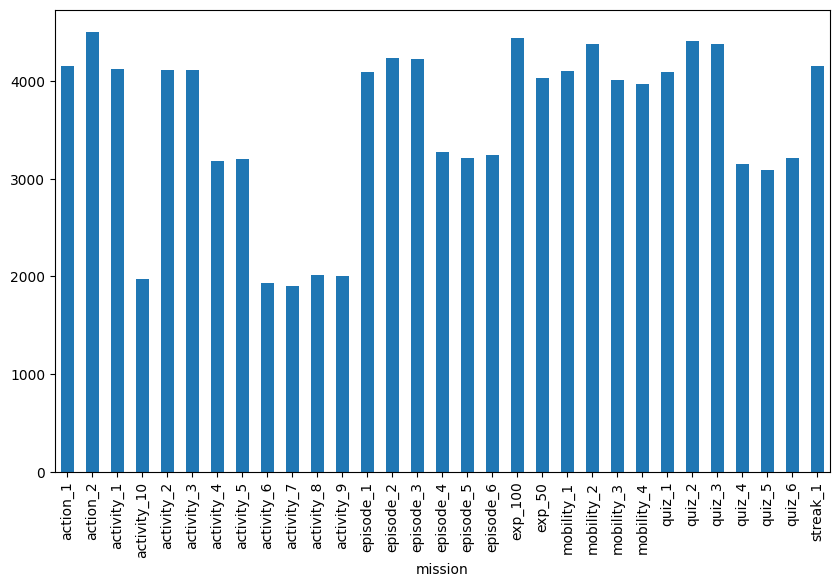

In [3]:
plt.figure(figsize=(10, 6))

df.groupby('mission', observed=True).size().plot(kind='bar')

In [4]:
def sequences(x: pd.Series, df: pd.DataFrame, day_window=3):
    ts = x['createdAtT']
    ts_start = ts - pd.Timedelta(days=day_window)

    user_df: pd.DataFrame = df[(df['user'] == x['user']) & (df['createdAtT'] >= ts_start) & (df['createdAtT'] < ts)]
    user_df = user_df.sort_values(by='createdAtT', ascending=True)
    return pd.Series({
        'id': str(x['user']) + '_' + str(ts),
        'ts': ts,
        'mission': x['mission'],
        'ID': x['mission_id'],
        'history': user_df[['mission_id', 'ok']].astype(int).values
    })

def get_negatives(x: pd.Series):
    neg = missions - set(x)
    return [list(neg)] * len(x)

df['ok'] = np.isclose(df['performance'], 1.0, rtol=0.15)
df['mission_id'] = df['mission'].cat.codes
missions = set(df['mission_id'])

sequences_df: pd.DataFrame = df[df['ok']].progress_apply(sequences, axis=1, args=(df,))
sequences_df['negatives'] = sequences_df.groupby('id')['ID'].transform(get_negatives)

sequences_df

  0%|          | 0/32004 [00:00<?, ?it/s]

,id,ts,mission,ID,history,negatives
2,0_2024-10-01,2024-10-01,episode_1,12,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,..."
3,0_2024-10-01,2024-10-01,quiz_1,24,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,..."
4,0_2024-10-01,2024-10-01,quiz_4,27,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,..."
6,2_2024-10-01,2024-10-01,action_1,0,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,2_2024-10-01,2024-10-01,quiz_5,28,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...,...
110950,8131_2024-11-07,2024-11-07,quiz_4,27,"[[24, 1], [1, 0], [3, 0], [26, 1], [8, 0], [19...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
110952,8135_2024-11-07,2024-11-07,episode_1,12,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,..."
110956,8153_2024-11-07,2024-11-07,streak_1,30,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
110960,8167_2024-11-07,2024-11-07,quiz_1,24,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [5]:
sequences_df['ts'] = pd.to_datetime(sequences_df['ts'])
sequences_df = sequences_df[sequences_df['history'].apply(len) > 0]
train_df = sequences_df[sequences_df['ts'] < pd.Timestamp('2024-11-01')]
test_df = sequences_df[sequences_df['ts'] >= pd.Timestamp('2024-11-01')]

display(train_df)
display(test_df)

,id,ts,mission,ID,history,negatives
3670,0_2024-10-02,2024-10-02,streak_1,30,"[[13, 0], [1, 0], [12, 1], [24, 1], [27, 1], [...","[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14..."
3671,0_2024-10-02,2024-10-02,activity_4,6,"[[13, 0], [1, 0], [12, 1], [24, 1], [27, 1], [...","[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14..."
3679,27_2024-10-02,2024-10-02,quiz_2,25,"[[20, 0], [29, 0], [7, 0]]","[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16..."
3680,27_2024-10-02,2024-10-02,episode_3,14,"[[20, 0], [29, 0], [7, 0]]","[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16..."
3681,27_2024-10-02,2024-10-02,activity_8,10,"[[20, 0], [29, 0], [7, 0]]","[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16..."
...,...,...,...,...,...,...
91346,8125_2024-10-31,2024-10-31,activity_1,2,"[[4, 1], [26, 0], [17, 1], [20, 0], [6, 1], [2...","[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
91347,8125_2024-10-31,2024-10-31,action_2,1,"[[4, 1], [26, 0], [17, 1], [20, 0], [6, 1], [2...","[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
91348,8125_2024-10-31,2024-10-31,episode_5,16,"[[4, 1], [26, 0], [17, 1], [20, 0], [6, 1], [2...","[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
91350,8131_2024-10-31,2024-10-31,quiz_1,24,"[[16, 0], [4, 0], [1, 0], [13, 0], [22, 0], [4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,..."


,id,ts,mission,ID,history,negatives
91360,12_2024-11-01,2024-11-01,quiz_2,25,"[[13, 0], [0, 1], [4, 1], [29, 1], [3, 1], [18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
91362,30_2024-11-01,2024-11-01,streak_1,30,"[[24, 1], [13, 1], [10, 1], [1, 1], [15, 1], [...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
91363,30_2024-11-01,2024-11-01,activity_6,8,"[[24, 1], [13, 1], [10, 1], [1, 1], [15, 1], [...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
91380,51_2024-11-01,2024-11-01,quiz_1,24,"[[21, 0], [4, 1], [15, 1], [7, 1], [17, 1], [1...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16..."
91381,51_2024-11-01,2024-11-01,episode_2,13,"[[21, 0], [4, 1], [15, 1], [7, 1], [17, 1], [1...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16..."
...,...,...,...,...,...,...
110911,8066_2024-11-07,2024-11-07,episode_3,14,"[[30, 1], [13, 1], [28, 1], [1, 0], [4, 1], [2...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
110917,8078_2024-11-07,2024-11-07,streak_1,30,"[[24, 0], [16, 0], [6, 0]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
110949,8131_2024-11-07,2024-11-07,activity_3,5,"[[24, 1], [1, 0], [3, 0], [26, 1], [8, 0], [19...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
110950,8131_2024-11-07,2024-11-07,quiz_4,27,"[[24, 1], [1, 0], [3, 0], [26, 1], [8, 0], [19...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [7]:
train_df.to_pickle('./data/train.pkl')
test_df.to_pickle('./data/test.pkl')